# Acquisition and Analysis

## Parse XML file

```1.``` Process a Wiktionary dump to extract synonym relations for a random language (not English, Ukrainian or Russian :). You can find the latest dumps at <https://dumps.wikimedia.org/backup-index.html>. The task requires application of XML SAX parsing.

```<page>``` -> ```<revision>``` -> ```<text xml:space="preserve">``` <br>

For german: dewiktionary-20190301-pages-articles-multistream.xml.bz2<br>

Example:
<text xml:space="preserve"><br>
== Hallo ({{Sprache|Deutsch}}) ==
{{Synonyme}}

:[1] [[Stamm]]


Output<br>
Word: Synonyms

In [24]:
import re
import xml.sax.handler
import xml.sax

syns = []

class GermanSynHandler(xml.sax.handler.ContentHandler):    
    def __init__(self):        
        self.in_text = False
        self.word = ''
        self.word_flag = False
        self.synonym_detected = False
        self.synonyms = []

    def startElement(self, name, attrs):        
        if name == 'text': #  xml:space="preserve"
            self.in_text = True    
            
    def characters(self, line):
        '''
        The structure of the xml file is as follows:
        <text ...>
            == Hallo ({{Sprache|Deutsch}}) ==
            ...
            {{Synonyme}}

            :[1] [[Stamm]]
        </text>
        '''
        re_word = re.compile('^== (.+) \({{Sprache\|Deutsch}}\) ==$')
        re_find_synonym = re.compile('^:\[1] \[\[(.+)]]')
        re_synonym = re.compile('\[\[([a-zA-ZäöüÄÖÜ]*)]]')  # äöüÄÖÜ - umlauts
    
        if self.in_text and line != '\n':
            if re_word.match(line):
                self.word = re_word.search(line).group(1)
                self.word_flag = True
            
            elif self.synonym_detected == True:
                 
                self.synonyms = re_synonym.findall(line)
                self.synonym_detected = False
                
                if self.word and self.synonyms:
                    syns.append((self.word, self.synonyms))
                
            elif (self.word_flag == True) and ('{{Synonyme}}' in line):
                self.synonym_detected = True

    def endElement(self, name):        
        if name == 'text':
            self.in_text = False
            
                
parser = xml.sax.make_parser() 
handler = GermanSynHandler() 
parser.setContentHandler(handler)
parser.parse('dewiktionary-20190301-pages-articles-multistream.xml')

In [22]:
# Conver to a DataFrame for visualization purpose
df = pd.DataFrame(syns, columns = ['word', 'synonyms'])
df

,word,synonyms
0,Hallo,[Gejohle]
1,Subfamilia,[Unterfamilie]
2,Subregnum,[Unterreich]
3,Phylum,[Stamm]
4,Superphylum,"[Überstamm, Hauptstamm, Stammgruppe]"
5,Subphylum,[Unterstamm]
6,Subordo,[Unterordnung]
7,Subgenus,[Untergattung]
8,Subspezies,"[Rasse, Unterart]"
9,Varietas,[Varietät]


## Web scraping

```2.``` Download and extract as separate texts all posts in a section of choice from <http://forum.lvivport.com>. The task requires web scraping.

Як поскрейпити (Львівський форум):<br>
HTML бібліотеки: 1) readibility, boilerpipe, 2) scrapy (scraping), 3) lazyweb 4) BeautifulSoup<br>

Обрана секція: Видатні львів'яни.<br>
http://forum.lvivport.com/forums/vidatni-lvivjani.69/<br>

Обраний метод:<br>
Парсити за допомогою requests i BeautifulSoup


In [249]:
import requests
import pandas as pd
import re
from bs4 import BeautifulSoup
%matplotlib inline
pd.set_option('display.max_colwidth', 500)

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# http://forum.lvivport.com/threads/vidatni-lvivjani.28346/page-2 - page-9
def data_from_lviv_forum(main_url):
    
    req = requests.get(main_url)
    soup = BeautifulSoup(req.text, 'html.parser')
    raw_list = soup.find_all('li', class_='discussionListItem')
    
    chat_urls = []
    for element in raw_list:
        chat_urls.append(element.find('div', class_='listBlock main').find('a', class_='PreviewTooltip')['href'])
    
    struct_data = []
    for chat_link in chat_urls:
        url = 'http://forum.lvivport.com/' + chat_link
        page_nav = requests.get(url)
        soup = BeautifulSoup(page_nav.text, 'html.parser')
        
        nav_res = soup.find("div", class_='PageNav', attrs={'data-page': True, 'data-last': True})
        if nav_res:
            start_page = int(nav_res['data-page'])
            last_page = int(nav_res['data-last'])
        else:
            start_page = 1
            last_page = 1
        
        for i in range(start_page, last_page + 1):
            
            result = requests.get(url + (('page-' + str(i)) if i>1 else ''))
            soup = BeautifulSoup(result.text, 'html.parser')
            raw_elements = soup.find_all("li", class_="message", attrs={'data-author': True})

            for element in raw_elements:
                data_author = element['data-author']
                author_title = element.find('em', class_='userTitle').text
                ukr_date = element.find('span', class_='DateTime', attrs={'title': True})['title']
                text = element.blockquote.text
                struct_data.append((data_author, author_title, ukr_date, text))

    return pd.DataFrame(struct_data, columns=['data_author', 'author_title', 'ukr_date', 'text'])

main_url = 'http://forum.lvivport.com/forums/vidatni-lvivjani.69/'
df = data_from_lviv_forum(main_url)
df.head(10)

,data_author,author_title,ukr_date,text
0,Тим22,Дуже важлива персона,1 жов 2007 у 16:04,"\n\n\n\n\n\n\n(adsbygoogle = window.adsbygoogle || []).push({});\n\n\n\n\n\t\t\t\t\tСреди них встречаются удивительные люди, например\n\r\nМухаммед Ассад или Мухаммад Асад (урождённый Леопольд Вайс) (1900—1991) — журналист, исламский писатель, дипломат, представитель Пакистана в ООН. Сын львовского еврейского адвоката, внук черновицкого раввина, после принятия в Германии ислама принял имя Мухаммед Ассад.\n\r\nЛеопольд Вайс родился в 1900 году во Львове в семье известного еврейского адвоката ..."
1,KabMiner,Well-Known Member,1 жов 2007 у 17:58,"\nВідповідь: Известные львовяне\n\nДійсно, справжній львівянин, та ще й ""відомий"", та щей звичайний аферист.\n \n"
2,Оля,Старожилка форуму,1 жов 2007 у 18:11,"\nВідповідь: Известные львовяне\n\n\n\nЦитата від KabMiner:\n\t\t\t\t\n\t\t\t\t\t↑\n\nДійсно, справжній львівянин, та ще й ""відомий"", та щей звичайний аферист.Натисніть, щоб розгорнути...\n\n Треба було гілку назвати ""Видатні аферисти зі Львова"". \n \n"
3,Пересвет,Well-Known Member,3 жов 2007 у 15:08,"\nВідповідь: Известные львовяне\n\n1) Леонид Исаакович Ярмольник родился 22 января 1954 года . \r\nВ 60-е годы семья Ярмольников обосновалась во Львове. Леонид учился в музыкальной школе, увлекался литературой и театром, занимался в театральной студии при Львовском Народном театре. \n\r\n2) Матвей Ганапольский-известный радио- и телеведущий Родился во Львове. В 1973 году окончил училище эстрадно-циркового искусства в Киеве, в 1981 – режиссерский факультет ГИТИСа. С 1981 по 1986 - режиссер-по..."
4,vasili,Well-Known Member,3 жов 2007 у 15:24,"\nВідповідь: Известные львовяне\n\n\r\nАльфред Виктор Редль\r\nAlfred Redl\r\n(1864- 26.05.1913 года )\r\nРоссия (russia)\n\r\nАльфред Виктор Редль родился в семье старшего железнодорожного инспектора в Лемберге, ныне Львове. После окончания кадетского училища и производства в офицеры в 1887 г. Редль был назначен адъютантом командира батальона одного из полков лембергского гарнизона. Вскоре его направляют в Венскую военную школу, по окончании которой он возвращается в свой полк. По делам слу..."
5,Бійцівська Рибка,амазонка,28 жов 2008 у 13:54,"\n\t\t\t\t\t\n\n\n\n\n\n\t\t\t\t\tВо Львове да-таки родилось много известных людей, наверное, больше, чем в Киеве. Есть чем гордиться.\n\t\t\t\t\t \n"
6,І.Павлович,Well-Known Member,28 жов 2008 у 14:13,"\n\t\t\t\t\t\n\n\n\n\n\n\t\t\t\t\tНа скільки я пам""ятаю, засновник мазохізма теж львівянин...\n\t\t\t\t\t \n"
7,duncan,батяр з личакова,28 жов 2008 у 14:24,"\n\n\nЦитата від І.Павлович:\n\t\t\t\t\n\t\t\t\t\t↑\n\nНа скільки я пам""ятаю, засновник мазохізма теж львівянин...Натисніть, щоб розгорнути...\n\n так точно, а ще кафе є в честь нього....\n\t\t\t\t\t \n"
8,Borodinka,Well-Known Member,4 лис 2008 у 10:12,"\nВацлав Залеський (Вацлав з Олеська) (1799 - 1849) - поет, драматург, театральний критик, публіцист, фольклорист, видавець першого у Галичині збірника ""Пісні польські і руські люду Галицького"" (1833, ще до ""Русалки Дністрової""), перший з поляків губернатор Галичини. А поза тим надзвичайно цікава і непересічна особистість.\n\t\t\t\t\t \n"
9,Полковник,миється в бані,4 лис 2008 у 10:26,"\n\n\nЦитата від Borodinka:\n\t\t\t\t\n\t\t\t\t\t↑\n\nВацлав Залеський (Вацлав з Олеська) (1799 - 1849) - поет, драматург, театральний критик, публіцист, фольклорист,Натисніть, щоб розгорнути...\n\nХм, вот думаю, а Пана НоТоЦо, поэта и композитора можно отнести к Видатним львів'янам?\nИли пока не дорос?\n\t\t\t\t\t \n"


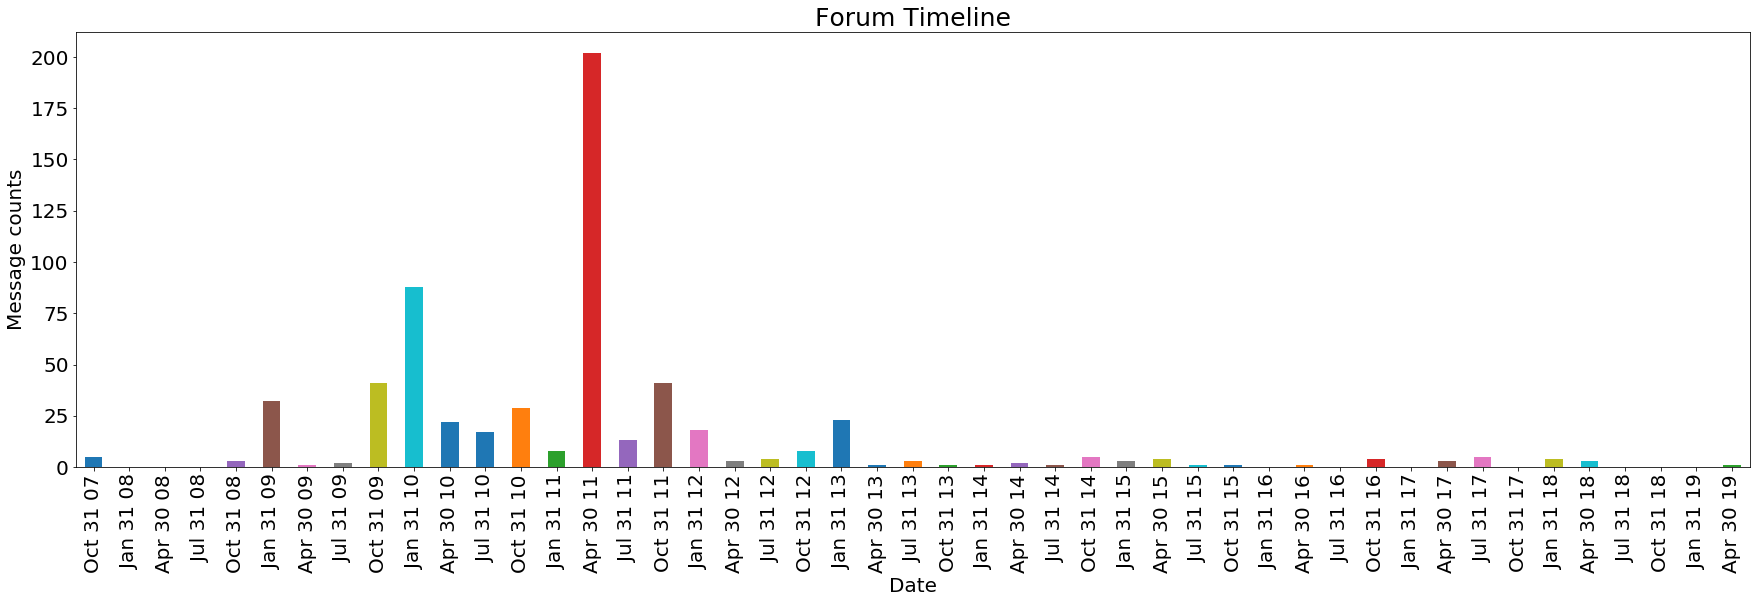

In [245]:
def transform_date(ukr_date):
    'Transform to the format = "%d/%m/%Y"'

    ukr_months = {'січ': 1,
                'лют': 2,
                'бер': 3,
                'кві': 4,
                'тра': 5,
                'чер': 6,
                'лип': 7,
                'сер': 8,
                'вер': 9,
                'жов': 10,
                'лис': 11,
                'гру': 12}
    
    day = re.findall('[0-9]{1,2}', ukr_date)[0]
    ukr_month = re.findall('[а-яіїє]{3}', ukr_date)[0]
    month = ukr_months.get(ukr_month)
    year = re.findall('[0-9]{4}', ukr_date)[0]
    return (f'{day}/{month}/{year}')


def show_forum_timeline(df_input):
    
    df = df_input.copy()
    df['date'] = pd.to_datetime(df['ukr_date'].map(lambda date: transform_date(date)),
                                format='%d/%m/%Y')

    df_viz = df.resample('3M', on='date')['date'].count()
    # df_viz.set
    ax = df_viz.plot(kind='bar', figsize=(30,8), fontsize=20)
    ax.set_title('Forum Timeline', fontsize=25)
    ax.set_xlabel('Date', fontsize=20)
    ax.set_ylabel('Message counts', fontsize=20)
    ax = ax.set_xticklabels(map(lambda x: x.strftime('%b %d %y'), df_viz.index))
    
    return None
    
show_forum_timeline(df)   

Висновки:
1. Дані зібрані прохоженням інтеративно по секції "Видатні львів'яни", по кожному чаті у цій секцій, по кожній сторінці чату. Про повідомлення витягнуті дані автор, опис автора, час і беспосередньо текст.
2. Візуалізувала знайдені дані відносно часу повідомлень. Для цього мені було необхідно перетворити текстові дані типу "3 жов 2007" у тип дату. Цікаво, що для знаходження місяців українською спрацювала регулярка '[а-яіїє]{3}'.

## SPARQL
```3.``` Write a query to collect all relations from dbpedia for every individual person listed in it. The task requires running a SPARQL request at <https://dbpedia.org/sparql>.
SPARQL: subj, pred, obj<br>

Дані: з dbpedia.org/ontology/ люди, їх дати народження і їх описи. Додала фільтр по мові опису, бо результатів для кожної людини було стільки ж, на скількох мовах є сторінки в Dbpedia.<br>

Query:<br>
```prefix dbo: <http://dbpedia.org/ontology/>
select ?p ?birth ?description where {
?p a dbo:Person .
?p dbo:birthDate ?birth .
?p dbo:abstract ?description
filter langMatches(lang(?description),"en")
}
limit 100```

In [22]:
# 1st way
import requests
import pandas as pd
import json

query = 'https://dbpedia.org/sparql?default-graph-uri=http%3A%2F%2Fdbpedia.org&query=prefix+dbo%3A+%3Chttp%3A%2F%2Fdbpedia.org%2Fontology%2F%3E%0D%0Aselect+%3Fp+%3Fbirth+%3Fdescription+where+%7B%0D%0A%3Fp+a+dbo%3APerson+.%0D%0A%3Fp+dbo%3AbirthDate+%3Fbirth+.%0D%0A%3Fp+dbo%3Aabstract+%3Fdescription%0D%0Afilter+langMatches%28lang%28%3Fdescription%29%2C%22en%22%29%0D%0A%7D%0D%0Alimit+100&format=application%2Fsparql-results%2Bjson&CXML_redir_for_subjs=121&CXML_redir_for_hrefs=&timeout=30000&debug=on&run=+Run+Query+'
response = requests.get(query)
response.text[:500]

2019-04-06 11:13:41 [urllib3.connectionpool] DEBUG: Starting new HTTPS connection (1): dbpedia.org
2019-04-06 11:13:42 [urllib3.connectionpool] DEBUG: https://dbpedia.org:443 "GET /sparql?default-graph-uri=http%3A%2F%2Fdbpedia.org&query=prefix+dbo%3A+%3Chttp%3A%2F%2Fdbpedia.org%2Fontology%2F%3E%0D%0Aselect+%3Fp+%3Fbirth+%3Fdescription+where+%7B%0D%0A%3Fp+a+dbo%3APerson+.%0D%0A%3Fp+dbo%3AbirthDate+%3Fbirth+.%0D%0A%3Fp+dbo%3Aabstract+%3Fdescription%0D%0Afilter+langMatches%28lang%28%3Fdescription%29%2C%22en%22%29%0D%0A%7D%0D%0Alimit+100&format=application%2Fsparql-results%2Bjson&CXML_redir_for_subjs=121&CXML_redir_for_hrefs=&timeout=30000&debug=on&run=+Run+Query+ HTTP/1.1" 200 101082


'\n{ "head": { "link": [], "vars": ["p", "birth", "description"] },\n  "results": { "distinct": false, "ordered": true, "bindings": [\n    { "p": { "type": "uri", "value": "http://dbpedia.org/resource/Andreas_Ekberg" }\t, "birth": { "type": "typed-literal", "datatype": "http://www.w3.org/2001/XMLSchema#date", "value": "1985-1-1" }\t, "description": { "type": "literal", "xml:lang": "en", "value": "Andreas Ekberg (born 2 January 1985) is a Swedish football referee. Ekberg currently resides in Malm\\u00F6'

In [53]:
# 2st way
from SPARQLWrapper import SPARQLWrapper, JSON

def get_person_data():
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    sparql.setQuery("""
        prefix dbo: <http://dbpedia.org/ontology/>
        select distinct ?p ?birthDate ?description where {
        ?p a dbo:Person .
        ?p dbo:birthDate ?birthDate .
        ?p dbo:abstract ?description
        filter langMatches(lang(?description),"en")
        }
        limit 100
    """)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    result_list = []
    for result in results["results"]["bindings"]:
        result_list.append([result["p"]["value"],
                            result["birthDate"]["value"],
                            result["description"]["value"]])
    df = pd.DataFrame(result_list, columns = ['url', 'birth_date', 'description'])
    df['name'] = df['url'].map(lambda row: row.split('/')[-1])
    return df.set_index('name')

get_person_data()[:10]

,url,birth_date,description
name,,,
Andreas_Ekberg,http://dbpedia.org/resource/Andreas_Ekberg,1985-1-1,Andreas Ekberg (born 2 January 1985) is a Swed...
Danilo_Tognon,http://dbpedia.org/resource/Danilo_Tognon,1937-10-9,"The Canoeist Danilo Tognon (born October 9, 19..."
Lorine_Livington_Pruette,http://dbpedia.org/resource/Lorine_Livington_P...,1896-1-1,Lorine Livington Pruette (1896–1977) was an Am...
Megan_Lawrence,http://dbpedia.org/resource/Megan_Lawrence,1972-1-1,Megan Lawrence (born 1972) is an American actr...
Nikolaos_Ventouras,http://dbpedia.org/resource/Nikolaos_Ventouras,1899-1-1,"Nikos Ventouras (August 31, 1899 – April 1, 19..."
Sani_ol_molk,http://dbpedia.org/resource/Sani_ol_molk,1814-1-1,Abu'l-Hasan Khan Ghaffari Kashani (1814–1866) ...
Siniša_Žugić,http://dbpedia.org/resource/Siniša_Žugić,1969-12-17,Siniša Žugić (Serbian: Синиша Жугић) (born Dec...
"William_Bagot,_2nd_Baron_Bagot","http://dbpedia.org/resource/William_Bagot,_2nd...",1773-9-11,"William Bagot, 2nd Baron Bagot (11 September 1..."
Witold_Gerutto,http://dbpedia.org/resource/Witold_Gerutto,1912-10-1,"Witold Gerutto (1 October 1912 in Harbin, Chin..."


Я реалізувала два варіанти як дістати дані з Dbpedia за допомогою SparQL:
1. За допомогою requests, запит сформований на https://dbpedia.org/sparql з відпоіддю в json-форматі
2. За допомогою пайтновіського SPARQLWrapper, який дає змогу формувати запит з середовища розробки; трохи перетворила формат і записала в dataframe.